# Задание 6

Подключаем необходимые библиотеки

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import itertools
import time
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim import Adam
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    StepLR,
    ExponentialLR
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve, 
    classification_report, 
    confusion_matrix, 
    multilabel_confusion_matrix, 
    accuracy_score, 
    auc, 
    f1_score, 
    precision_score, 
    recall_score
)
from sklearn.utils import shuffle

## Задание 1 
Сформируйте тренировочный датасет. 

In [6]:
n = 80000
s = 50000
skip = sorted(random.sample(range(n), n - s))

In [8]:
df_mitbih_train = pd.read_csv('./mitbih_train.csv', header=None, skiprows=skip)
df_mitbih_test = pd.read_csv('./mitbih_test.csv', header=None, skiprows=skip)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

In [10]:
# датасет размечен на 5 классов, в исходном датасете столбец №187 содержит номер класса
df_mitbih.rename(columns={187: 'class'}, inplace=True)

df_mitbih_test.rename(columns={187: 'class'}, inplace=True)
df_mitbih_train.rename(columns={187: 'class'}, inplace=True)

In [12]:
id_to_label = {
    0: 'Normal',     #0: "Нормальный"
    1: 'Artial Premature', # "Преждевременное сокращение сердца (экстрасистолия)"
    2: 'Premature ventricular contraction', # "Преждевременное сокращение желудочков"
    3: 'Fusion of ventricular and normal',  # "Cлияние желудочкового и нормального сердечного ритма"
    4: 'Fusion of paced and normal' #"Cлияние стимулированного и нормального ритма"
}

df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
df_mitbih_test['label'] = df_mitbih_test.iloc[:, -1].map(id_to_label)
df_mitbih_train['label'] = df_mitbih_train.iloc[:, -1].map(id_to_label)


print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 71224 entries, 0 to 13669
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 103.2+ MB
None


In [14]:
df_mitbih_train['class'].value_counts() # Классы несбалансированы

class
0.0    45277
4.0     6431
2.0     3801
1.0     1404
3.0      641
Name: count, dtype: int64

In [16]:
#создаем процедуру перемешивания данных и их балансировки
df_mitbih_test = shuffle(df_mitbih_test)
df_mitbih_train = shuffle(df_mitbih_train)

df_mitbih_test = df_mitbih_test.reset_index(drop='True')
df_mitbih_train = df_mitbih_train.reset_index(drop='True')

In [18]:
rus_method = RandomUnderSampler()

df = df_mitbih_train
df.columns = df.columns.astype(str)
X_resampled, y_resampled = rus_method.fit_resample(df.loc[:, df.columns != 'class'], df['class'])

new_df =pd.concat([X_resampled, y_resampled], axis=1)
new_df = new_df.dropna()

new_df['class'].value_counts()

class
0.0    641
1.0    641
2.0    641
3.0    641
4.0    641
Name: count, dtype: int64

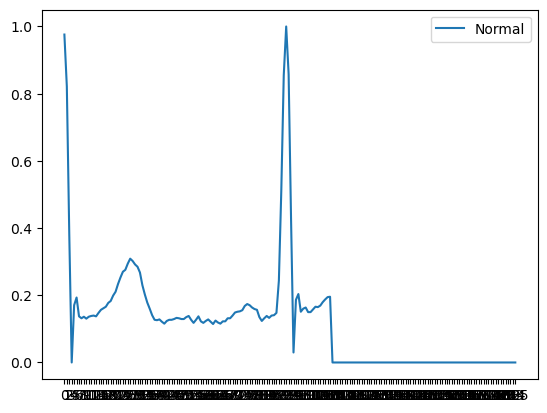

In [20]:
# пример как выглядит кардиограмма из датасета
plt.plot(df_mitbih_train.iloc[0][:-3], label=str(df_mitbih_train.iloc[0]['label']))
plt.legend()
plt.show()

## Задание 2- 3
Постройте нейронную сеть с эффектом памяти (LSTM) и примените механизм внимания.
Обучите ее классифицировать классы по заданной ЭКГ. Постройте матрицу ошибок (confusion matrix).

In [27]:
class ECGDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-3].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        
        return signal, target

    def __len__(self):
        return len(self.df)

In [29]:
def get_dataloader(df, phase: str, batch_size: int = 96):
    train_df, val_df = train_test_split(df, test_size=0.15, random_state=123, stratify=df['label'])
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    df = train_df if phase == 'train' else val_df
    
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    
    return dataloader

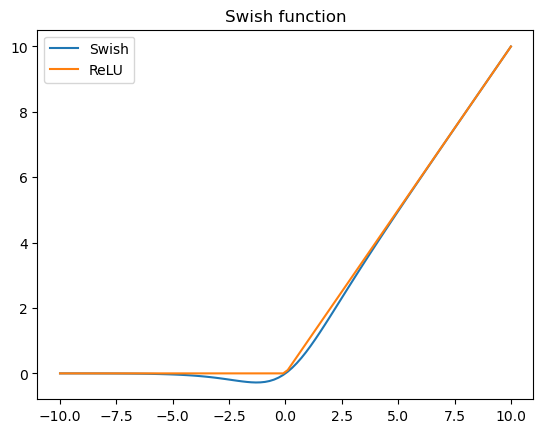

In [31]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()

In [33]:
class RNN(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p=0.2,
        bidirectional=False,
    ):
        super().__init__()
        self.rnn_layer = nn.LSTM(
            input_size=input_size,
            hidden_size=hid_size,
            num_layers=num_rnn_layers,
            dropout=dropout_p if num_rnn_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True,
        )
    
    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

In [35]:
class ConvNormPool(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

In [37]:
class RNNAttentionModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,
            hid_size=hid_size,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [39]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion
     

In [41]:
class Trainer:
    def __init__(self, df, net, lr, batch_size, num_epochs):
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(df, phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()
        
    def _train_epoch(self, phase, net):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        net.train() if phase == 'train' else net.eval()
        meter = Meter()
        meter.init_metrics()

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            target = target.to(device)
            
            output = net(data)
            loss = self.criterion(output, target)

            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            meter.update(output, target, loss.item())
            
        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        print(
            '{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'.format(*(x for kv in metrics.items() for x in kv))
        )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss
    
    def run(self, net):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train',net=net)
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val',net=net)
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                torch.save(net.state_dict(), f"best_model_epoc{epoch}.pth")

In [43]:
model = RNNAttentionModel(1, 64, bidirectional=False)

train mode | time: 11:27:26
loss: 1.3409937788458433, accuracy: 0.5915441176470588, f1: 0.5410657684370891, precision: 0.5987406972112854, recall: 0.6399054299188338


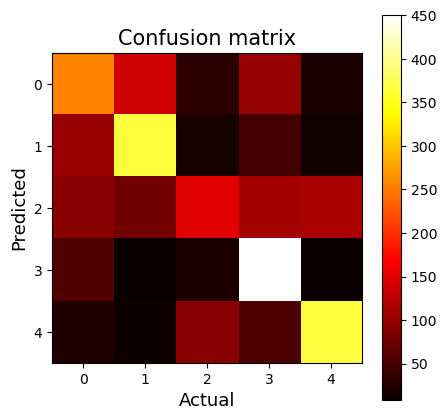

val mode | time: 11:27:30
loss: 1.2328922470410666, accuracy: 0.8229166666666666, f1: 0.8158392537401826, precision: 0.8357739297739298, recall: 0.8426190476190476


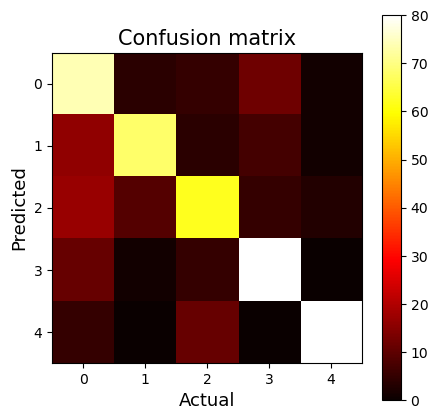


New checkpoint

train mode | time: 11:27:31
loss: 1.1585621497210334, accuracy: 0.7669117647058824, f1: 0.7464586441388955, precision: 0.7725639262698087, recall: 0.7703051850110673


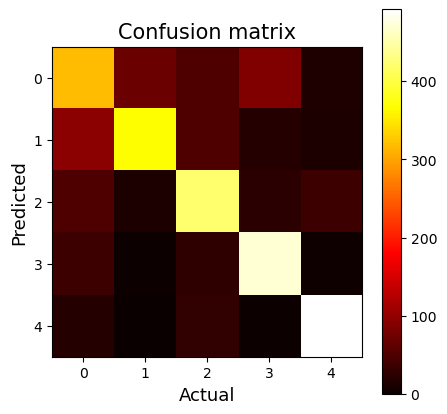

val mode | time: 11:27:35
loss: 1.150329013665517, accuracy: 0.88125, f1: 0.8727127218613286, precision: 0.8912659932659932, recall: 0.8820711880711882


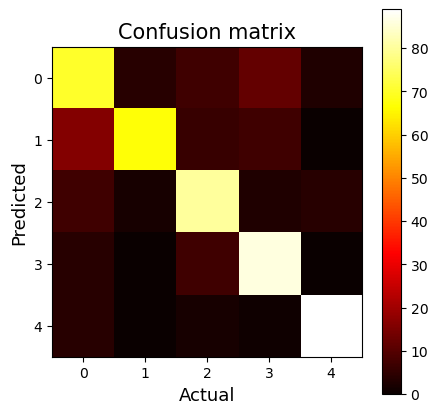


New checkpoint

train mode | time: 11:27:36
loss: 1.1191562862957225, accuracy: 0.8073529411764706, f1: 0.7915890855746975, precision: 0.8109937121701827, recall: 0.8124041187570596


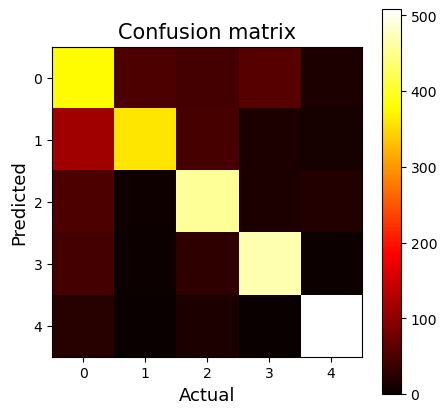

val mode | time: 11:27:40
loss: 1.1673579255739848, accuracy: 0.8604166666666667, f1: 0.8461675182975494, precision: 0.8648595478595478, recall: 0.8552996632996633


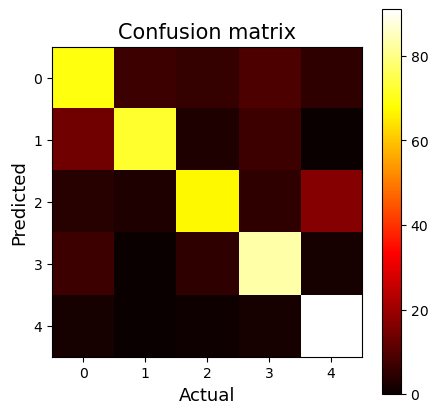


New checkpoint

train mode | time: 11:27:40
loss: 1.1046298475826488, accuracy: 0.8213235294117647, f1: 0.8049759654087213, precision: 0.8187185167773404, recall: 0.8339783941548649


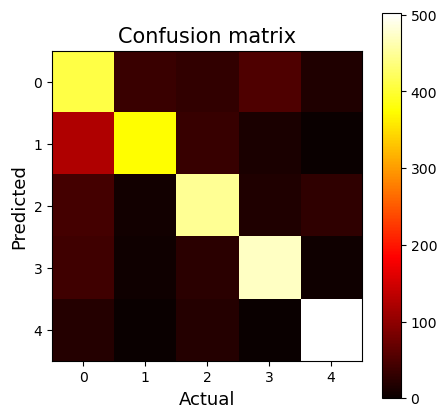

val mode | time: 11:27:44
loss: 1.1379050334294638, accuracy: 0.8895833333333333, f1: 0.8813253388052149, precision: 0.9002390572390572, recall: 0.8909927849927849


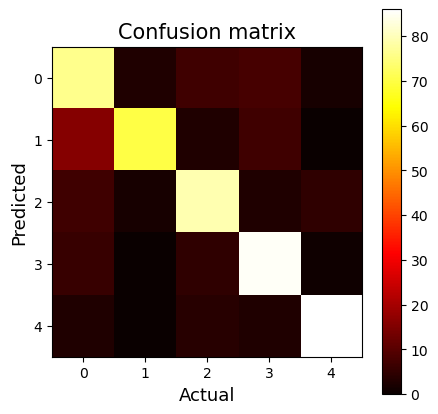

train mode | time: 11:27:45
loss: 1.0845871876267825, accuracy: 0.8444852941176471, f1: 0.829839121850738, precision: 0.8452818553995025, recall: 0.851330995801584


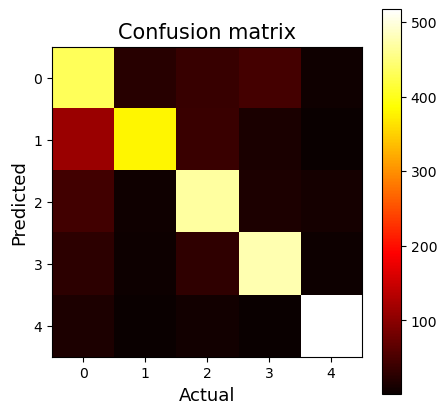

val mode | time: 11:27:49
loss: 1.129801877339681, accuracy: 0.9020833333333333, f1: 0.8944449837514851, precision: 0.9107123617123616, recall: 0.9053535353535352


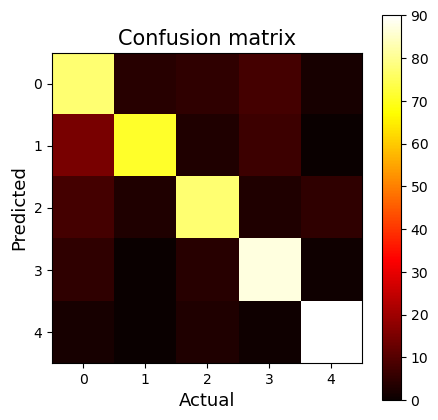


New checkpoint

train mode | time: 11:27:49
loss: 1.0705435423290028, accuracy: 0.8595588235294118, f1: 0.8452244887532921, precision: 0.8587779932485815, recall: 0.8634110921757981


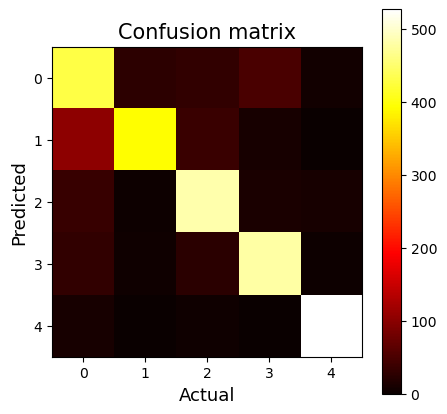

val mode | time: 11:27:53
loss: 1.1446970502535503, accuracy: 0.8916666666666667, f1: 0.884451467922056, precision: 0.9003357383357385, recall: 0.9001139971139971


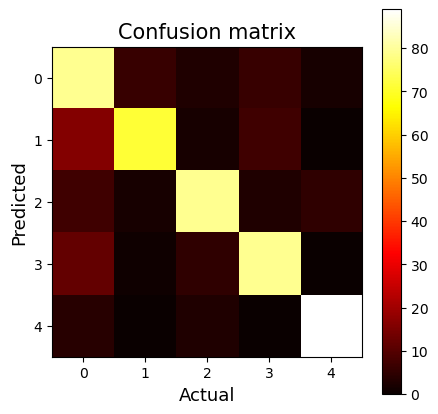


New checkpoint

train mode | time: 11:27:54
loss: 1.0611832555602578, accuracy: 0.8650735294117647, f1: 0.8541282160629805, precision: 0.8677648364707187, recall: 0.8733665615430316


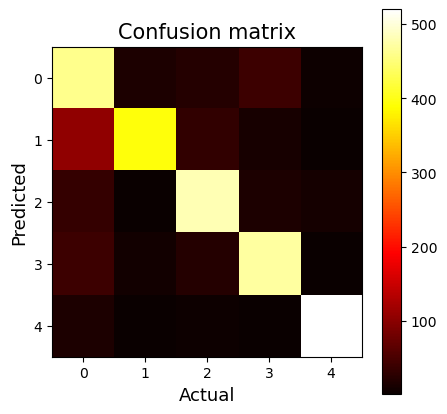

val mode | time: 11:27:58
loss: 1.1289196332295737, accuracy: 0.9, f1: 0.8932029974382917, precision: 0.908976430976431, recall: 0.9007267917267917


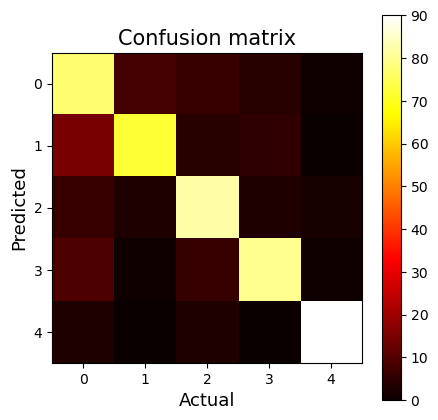

train mode | time: 11:27:58
loss: 1.0451746141209322, accuracy: 0.8827205882352941, f1: 0.8743423629514969, precision: 0.8856866597454833, recall: 0.8932117163881865


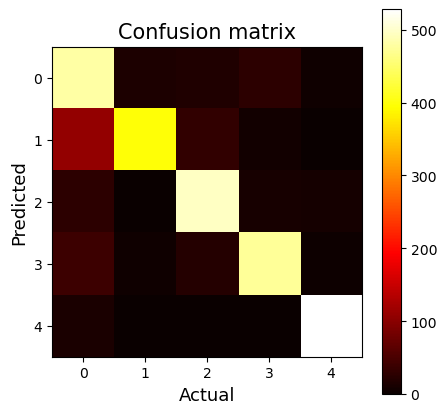

val mode | time: 11:28:03
loss: 1.1260060866673787, accuracy: 0.90625, f1: 0.9022140275731607, precision: 0.9175209235209235, recall: 0.9154935064935065


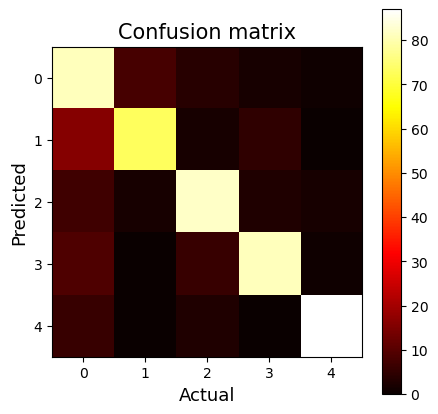

train mode | time: 11:28:03
loss: 1.0400684987797457, accuracy: 0.888235294117647, f1: 0.8795778913633758, precision: 0.8908855654149771, recall: 0.8967659334129918


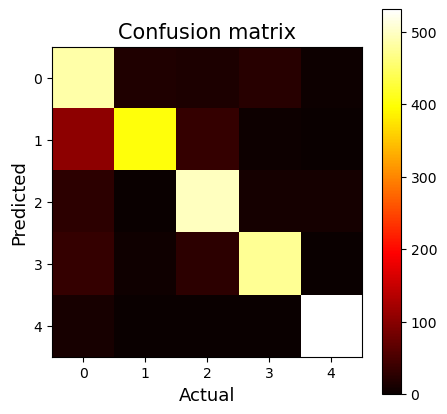

val mode | time: 11:28:07
loss: 1.1259141325950623, accuracy: 0.8979166666666667, f1: 0.8883666760942303, precision: 0.9076483886483885, recall: 0.8981361231361231


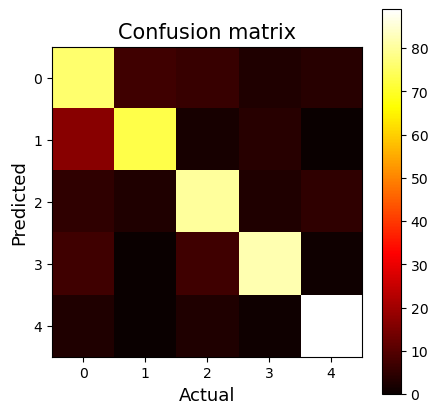

train mode | time: 11:28:08
loss: 1.0356415096451255, accuracy: 0.8915441176470589, f1: 0.8833681953456081, precision: 0.8939230573348221, recall: 0.9020521896404244


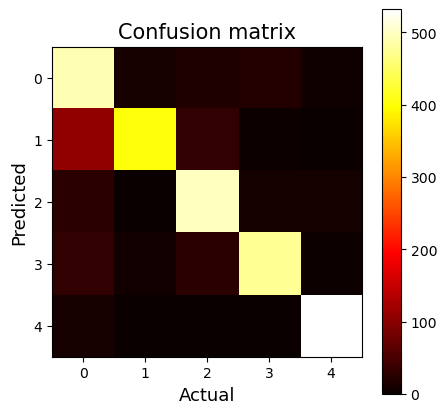

val mode | time: 11:28:12
loss: 1.1214205384254456, accuracy: 0.90625, f1: 0.8989844676593902, precision: 0.9167753727753727, recall: 0.9066666666666666


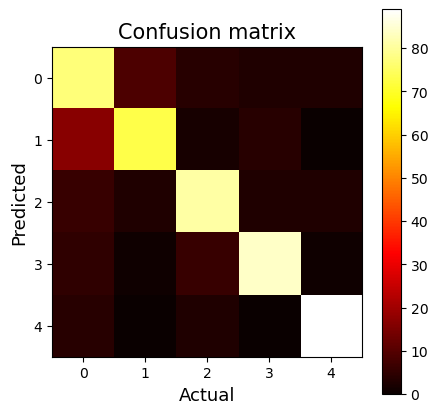

In [45]:
trainer = Trainer(df=new_df, net=model, lr=1e-3, batch_size=32, num_epochs=10)
trainer.run(net=model)

In [46]:
train_logs = []
val_logs = []

train_logs = trainer.train_df_logs
train_logs.columns = ['train_' + colname for colname in train_logs.columns]
val_logs = trainer.val_df_logs
val_logs.columns = ['val_' + colname for colname in val_logs.columns]

logs = pd.concat([train_logs, val_logs], axis=1)
logs.reset_index(drop=True, inplace=True)
logs = logs.loc[:, [
    'train_loss', 'val_loss',
    'train_accuracy', 'val_accuracy',
    'train_f1', 'val_f1',
    'train_precision', 'val_precision',
    'train_recall', 'val_recall']
]
logs.head()

,train_loss,val_loss,train_accuracy,val_accuracy,train_f1,val_f1,train_precision,val_precision,train_recall,val_recall
0,1.340994,1.232892,0.591544,0.822917,0.541066,0.815839,0.598741,0.835774,0.639905,0.842619
1,1.158562,1.150329,0.766912,0.881250,0.746459,0.872713,0.772564,0.891266,0.770305,0.882071
2,1.119156,1.167358,0.807353,0.860417,0.791589,0.846168,0.810994,0.864860,0.812404,0.855300
3,1.104630,1.137905,0.821324,0.889583,0.804976,0.881325,0.818719,0.900239,0.833978,0.890993
4,1.084587,1.129802,0.844485,0.902083,0.829839,0.894445,0.845282,0.910712,0.851331,0.905354


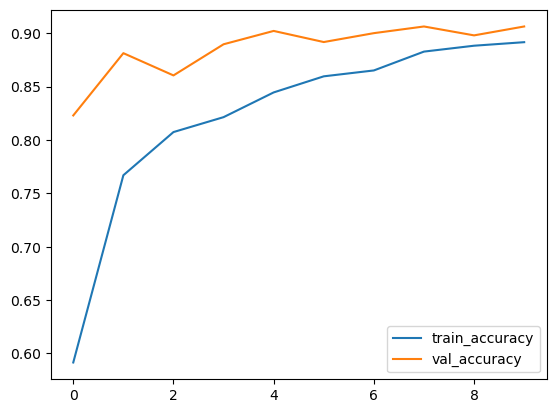

In [47]:
plt.plot(logs['train_accuracy'], label='train_accuracy')
plt.plot(logs['val_accuracy'], label='val_accuracy' )
plt.legend()
plt.show()

In [48]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)

            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)

            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    
    return predictions_cls, ground_truths_cls

In [49]:
test_dataset = ECGDataset(df_mitbih_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=0, shuffle=False)

In [50]:
df_mitbih_test['label'].value_counts()

label
Normal                               11300
Fusion of paced and normal            1029
Premature ventricular contraction      889
Artial Premature                       341
Fusion of ventricular and normal       111
Name: count, dtype: int64

In [51]:
y_pred, y_true = make_test_stage(test_dataloader, model)
y_pred.shape, y_true.shape

((13670,), (13670,))

In [52]:
def print_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots() 

    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        xticklabels=df['label'].unique(),
        yticklabels=df['label'].unique(),
        cmap='Oranges'
    )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

<Figure size 800x600 with 0 Axes>

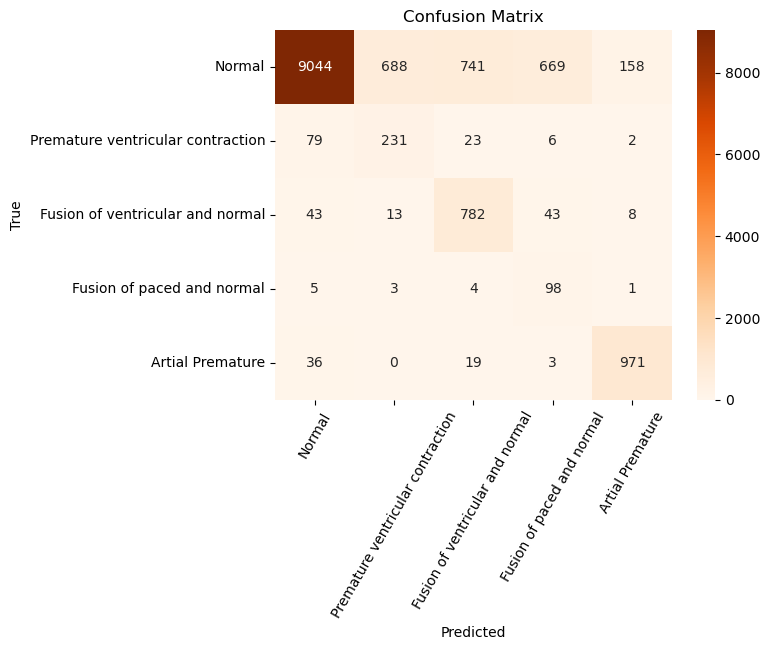

In [53]:
print_cm(y_true, y_pred)

In [54]:
print(multilabel_confusion_matrix(y_true, y_pred))

[[[ 2207   163]
  [ 2256  9044]]

 [[12625   704]
  [  110   231]]

 [[11994   787]
  [  107   782]]

 [[12838   721]
  [   13    98]]

 [[12472   169]
  [   58   971]]]


In [55]:
print(f'Accuracy для тестовых данных: {accuracy_score(y_true, y_pred)}')

Accuracy для тестовых данных: 0.813899049012436


## Задание 4
Проведите эксперименты по заданию на AutoML решении. Сравните результаты.

### AutoML LAMA

In [93]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [95]:
df = df_mitbih_train
df.columns = df.columns.astype(str)
X_resampled, y_resampled = rus_method.fit_resample(df.loc[:, df.columns != 'class'], df['class'])

new_df = pd.concat([X_resampled, y_resampled], axis=1)
new_df = new_df.dropna()

new_df['class'].value_counts()

class
0.0    641
1.0    641
2.0    641
3.0    641
4.0    641
Name: count, dtype: int64

In [97]:
dfs = []
for i in range(5):
    dfs.append(new_df[new_df['class'] == i].tail(200))
    
new_short_df = pd.concat(dfs, axis=0)
new_short_df['class'].value_counts()

class
0.0    200
1.0    200
2.0    200
3.0    200
4.0    200
Name: count, dtype: int64

In [99]:
new_df_train = new_short_df.drop('label', axis=1)

In [101]:
automl = TabularAutoML(
    task = Task('multiclass'),
    reader_params = {'cv': 2, 'random_state': 10},
)

In [103]:
predictions = automl.fit_predict(new_df_train, roles={'target': 'class'}, verbose=1).data

[11:35:15] Stdout logging level is INFO.
[11:35:15] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[11:35:15] Task: multiclass

[11:35:15] Start automl preset with listed constraints:
[11:35:15] - time: 3600.00 seconds
[11:35:15] - CPU: 4 cores
[11:35:15] - memory: 16 GB

[11:35:15] Train data shape: (1000, 188)

[11:35:19] Layer 1 train process start. Time left 3596.55 secs
[11:35:19] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:35:21] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.7695455592750975
[11:35:21] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:35:21] Time left 3594.61 secs

[11:35:22] Selector_LightGBM fitting and predicting completed
[11:35:22] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[11:35:24] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.5265422696541012
[11:35:24] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[11:35:24] Start hyperparameters optimization

Optimization Progress: 100%|███████████████████████| 101/101 [02:18<00:00,  1.37s/it, best_trial=83, best_value=-0.501]

[11:37:42] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[11:37:42] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[11:37:43] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.5261750227999856
[11:37:43] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[11:37:43] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[11:37:49] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.45855000697576903
[11:37:49] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[11:37:49] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:  28%|██████▋                 | 28/101 [05:35<14:33, 11.97s/it, best_trial=27, best_value=-0.459]

[11:43:24] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[11:43:24] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[11:44:48] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.4498781219158122
[11:44:48] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[11:44:48] Time left 3027.30 secs

[11:44:48] Layer 1 training completed.

[11:44:48] Layer 2 train process start. Time left 3027.28 secs
[11:44:48] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[11:44:50] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.5804902669773234
[11:44:50] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:44:50] Time left 3025.57 secs

[11:44:50] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
[11:44:52] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -0.5265422696541012
[11:44:52] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[11:44:52] Time left 3023.47 secs

[11:44:52] Layer 2 training completed.

[11:44:52] Blending: optimization starts with equal weights. Score = -0.5360703
[11:44:52] Blending: iteration 0: score = -0.5253541, weights = [0.10578663

In [129]:
df = df_mitbih_test
df.columns = df.columns.astype(str)
X_resampled, y_resampled = rus_method.fit_resample(df.loc[:, df.columns != 'class'], df['class'])

new_df = pd.concat([X_resampled, y_resampled], axis=1)
new_df = new_df.dropna()

new_df_test = new_df.drop('label', axis=1)

In [131]:
test_predictions = automl.predict(new_df_test).data

In [133]:
with open('./lightautoml_model_task6.pkl', 'wb') as f:
    pickle.dump(automl, f)

In [134]:
print(automl.create_model_str_desc())

Models on level 0:
	 2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 0.10579 * (2 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
	 0.89421 * (2 averaged models Lvl_1_Pipe_1_Mod_0_LightGBM) 


In [137]:
algo = automl.levels[0][0].ml_algos[0]
model = algo.models[0]

print(
    f'Алгоритм - {type(algo).__name__}\nМодель - {type(model).__name__}\n'
    f'Функция потерь - {model.model}\nАрхитектура = {model.loss}'
)

Алгоритм - LinearLBFGS
Модель - TorchBasedLogisticRegression
Функция потерь - CatMulticlass(
  (linear): Linear(in_features=187, out_features=5, bias=False)
  (final_act): SoftmaxClip(
    (smax): Softmax(dim=1)
  )
)
Архитектура = TorchLossWrapper(
  (base_loss): CrossEntropyLoss()
)


In [139]:
predictions_classes = np.argmax(predictions, axis = 1)
test_predictions_classes = np.argmax(test_predictions, axis = 1)
train_classes = new_df_train['class']
test_classes = new_df_test['class']

In [141]:
(
    f'Accuracy для обучающих данных: {accuracy_score(train_classes, predictions_classes)}',
    f'Accuracy для тестовых данных: {accuracy_score(test_classes, test_predictions_classes)}'
)

('Accuracy для обучающих данных: 0.803',
 'Accuracy для тестовых данных: 0.8036036036036036')

In [143]:
print(multilabel_confusion_matrix(test_classes, test_predictions_classes))

[[[392  52]
  [ 26  85]]

 [[427  17]
  [ 36  75]]

 [[424  20]
  [ 20  91]]

 [[428  16]
  [ 13  98]]

 [[440   4]
  [ 14  97]]]


<Figure size 800x600 with 0 Axes>

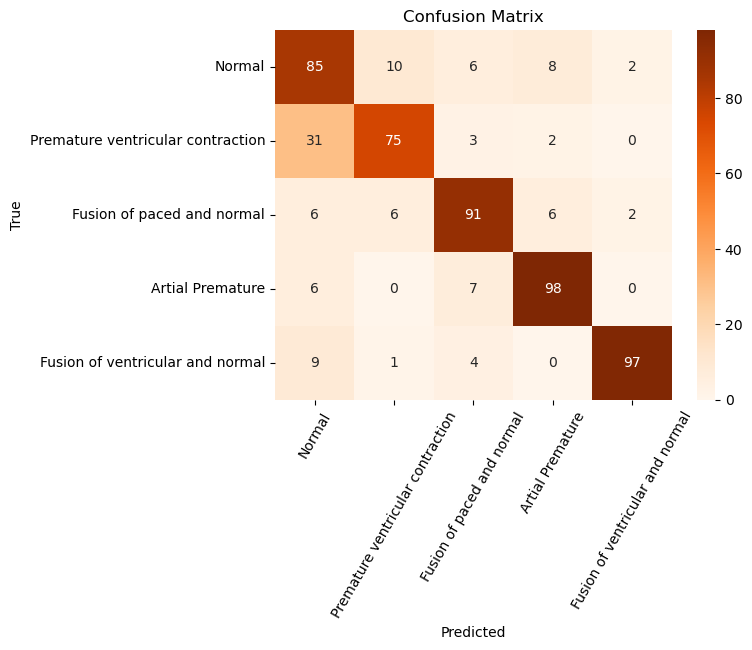

In [145]:
print_cm(test_classes, test_predictions_classes)

In [147]:
import mlflow
from mlflow.models import infer_signature

In [149]:
import subprocess
from threading import Thread

def start_mlflow():
    subprocess.run(["mlflow", "ui", "--host", "0.0.0.0", "--port", "5000"])

Thread(target=start_mlflow, daemon=True).start()

In [151]:
mlflow.set_tracking_uri(uri='http://localhost:5000')
mlflow.set_experiment('Task 6')

<Experiment: artifact_location='mlflow-artifacts:/760273242643663123', creation_time=1745048093184, experiment_id='760273242643663123', last_update_time=1745048093184, lifecycle_stage='active', name='Task 6', tags={}>

In [153]:
with mlflow.start_run(run_name='LAMA'):
    mlflow.log_params(
        {
            'cv': 5, 
            'random_state': 0
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy для обучающих данных': accuracy_score(train_classes, predictions_classes),
            'Accuracy для тестовых данных': accuracy_score(test_classes, test_predictions_classes),
        }
    )
    mlflow.log_artifact('./lightautoml_model_task6.pkl')
    
    model_info = mlflow.sklearn.log_model(
        sk_model=automl,
        artifact_path='lightautoml_model_task6',
        signature=infer_signature(new_df_train, predictions_classes),
        input_example=new_df_train,
    )

🏃 View run LAMA at: http://localhost:5000/#/experiments/760273242643663123/runs/5485959fdbaa435cbb5d7a368f2bd911
🧪 View experiment at: http://localhost:5000/#/experiments/760273242643663123


### AutoML H2O

In [108]:
import h2o
from h2o.automl import H2OAutoML
import mlflow
import pickle
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix

# Инициализация H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 21.0.5+-13047016-b750.29, mixed mode)
  Starting server from C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\dvm10\AppData\Local\Temp\tmpwjprn6ki
  JVM stdout: C:\Users\dvm10\AppData\Local\Temp\tmpwjprn6ki\h2o_dvm10_started_from_python.out
  JVM stderr: C:\Users\dvm10\AppData\Local\Temp\tmpwjprn6ki\h2o_dvm10_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,5 months and 17 days
H2O_cluster_name:,H2O_from_python_dvm10_l1pd38
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.932 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


In [109]:
# Преобразование данных в H2OFrame
train_h2o = h2o.H2OFrame(new_df_train)
test_h2o = h2o.H2OFrame(new_df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [110]:
# Указываем предикторы и целевую переменную
predictors = [col for col in train_h2o.columns if col != 'class']
target = 'class'

In [111]:
# Преобразуем целевую переменную в категориальную (для классификации)
train_h2o[target] = train_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()

In [112]:
# Настройка и запуск H2O AutoML
aml = H2OAutoML(
    max_models=5,          # Аналог generations в TPOT
    max_runtime_secs=300,  # Ограничение времени выполнения
    seed=42,               # Для воспроизводимости
    verbosity="info",      # Уровень детализации вывода
    exclude_algos=["StackedEnsemble"]  # Опционально: исключаем ансамбли
)

# Обучение модели
aml.train(x=predictors, y=target, training_frame=train_h2o)

# Получаем лучшую модель
best_model = aml.leader

AutoML progress: |
10:36:11.59: Project: AutoML_1_20250419_103611
10:36:11.60: 5-fold cross-validation will be used.
10:36:11.62: Setting stopping tolerance adaptively based on the training frame: 0.03162277660168379
10:36:11.62: Build control seed: 42
10:36:11.62: training frame: Frame key: AutoML_1_20250419_103611_training_py_1_sid_8c20    cols: 188    rows: 1000  chunks: 1    size: 1110342  checksum: -5256173732904124524
10:36:11.62: validation frame: NULL
10:36:11.62: leaderboard frame: NULL
10:36:11.62: blending frame: NULL
10:36:11.62: response column: class
10:36:11.62: fold column: null
10:36:11.62: weights column: null
10:36:11.68: AutoML: XGBoost is not available; skipping it.
10:36:11.70: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w),

In [113]:
# Делаем предсказания
train_pred = best_model.predict(train_h2o)
test_pred = best_model.predict(test_h2o)

# Извлекаем предсказанные классы
y_train_predict = train_pred['predict'].as_data_frame().values.flatten()
y_test_predict = test_pred['predict'].as_data_frame().values.flatten()

# Получаем истинные значения
y_train_true = train_h2o[target].as_data_frame().values.flatten()
y_test_true = test_h2o[target].as_data_frame().values.flatten()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\dvm10\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and 

In [114]:
(
    f'Accuracy для обучающих данных: {accuracy_score(y_train_true, y_train_predict)}',
    f'Accuracy для тестовых данных: {accuracy_score(y_test_true, y_test_predict)}'
)

('Accuracy для обучающих данных: 1.0', 'Accuracy для тестовых данных: 1.0')

In [115]:
model_path = h2o.save_model(best_model, path="./", force=True)

In [116]:
# Логирование в MLflow
with mlflow.start_run(run_name='H2O_AutoML'):
    # Параметры
    mlflow.log_params({
        'max_runtime_secs': 300,
        'seed': 42,
        'algorithm': best_model.algo
    })
    
    # Метрики
    mlflow.log_metrics({
        'Accuracy_train': accuracy_score(y_train_true, y_train_predict),
        'Accuracy_test': accuracy_score(y_test_true, y_test_predict),
    })
    
    # Артефакты
    mlflow.log_artifact(model_path)
    
    # Логирование модели H2O
    mlflow.h2o.log_model(
        h2o_model=best_model,
        artifact_path='h2o_model',
        registered_model_name='H2O_AutoML_Model'
    )

2025/04/19 10:37:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'H2O_AutoML_Model' already exists. Creating a new version of this model...
2025/04/19 10:37:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: H2O_AutoML_Model, version 2


🏃 View run H2O_AutoML at: http://localhost:5000/#/experiments/760273242643663123/runs/db974a90eb95411a85d7e1c198fde16b
🧪 View experiment at: http://localhost:5000/#/experiments/760273242643663123


Created version '2' of model 'H2O_AutoML_Model'.


In [117]:
h2o.shutdown()

H2O session _sid_8c20 closed.


C:\Users\dvm10\AppData\Local\Temp\ipykernel_5576\2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


### AutoML FEDOT

In [132]:
from fedot.api.main import Fedot

In [134]:
X_train = new_df_train.iloc[:, new_df_train.columns != 'class'].values
y_train = new_df_train.iloc[:, new_df_train.columns == 'class'].values.reshape(-1)

In [146]:
X_test = new_df_test.iloc[:, new_df_test.columns != 'class'].values
y_test = new_df_test.iloc[:, new_df_test.columns == 'class'].values.reshape(-1)

In [138]:
automl_model = Fedot(
    problem='classification',
    preset='fast_train',
    available_operations=['rf', 'logit','mlp', 'xgboost'],
    with_tuning=True,
    n_jobs=-1,
    seed=42
)

In [140]:
automl_model.fit(X_train, y_train)

2025-04-19 10:43:03,115 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-19 10:43:05,435 - ApiComposer - Initial pipeline was fitted in 1.3 sec.
2025-04-19 10:43:05,436 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 6.3 sec.
2025-04-19 10:43:05,445 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 5.0 min. Set of candidate models: ['rf', 'logit', 'mlp', 'xgboost'].
2025-04-19 10:43:05,463 - ApiComposer - Pipeline composition started.


Generations:   0%|                                                                          | 0/10000 [00:00<?, ?gen/s]

2025-04-19 10:43:15,194 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2025-04-19 10:44:03,297 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2025-04-19 10:44:14,035 - MultiprocessingDispatcher - 16 individuals out of 16 in previous population were evaluated successfully.
2025-04-19 10:44:15,253 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|                                                              | 1/10000 [01:09<193:47:48, 69.77s/gen]

2025-04-19 10:44:18,213 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2025-04-19 10:44:19,784 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


Generations:   0%|                                                               | 2/10000 [01:14<87:11:47, 31.40s/gen]

2025-04-19 10:44:30,154 - MultiprocessingDispatcher - 31 individuals out of 31 in previous population were evaluated successfully.
2025-04-19 10:44:36,058 - MultiprocessingDispatcher - 19 individuals out of 19 in previous population were evaluated successfully.
2025-04-19 10:44:41,676 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.


Generations:   0%|                                                               | 3/10000 [01:36<75:08:43, 27.06s/gen]

2025-04-19 10:45:11,228 - MultiprocessingDispatcher - 50 individuals out of 50 in previous population were evaluated successfully.
2025-04-19 10:45:11,244 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.


Generations:   0%|                                                               | 4/10000 [02:05<77:52:19, 28.05s/gen]

2025-04-19 10:45:41,892 - MultiprocessingDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.
2025-04-19 10:45:42,817 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|                                                               | 5/10000 [02:37<81:23:56, 29.32s/gen]

2025-04-19 10:45:42,856 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                               | 5/10000 [02:37<87:23:11, 31.47s/gen]

2025-04-19 10:45:42,889 - ApiComposer - Hyperparameters tuning started with 2 min. timeout


2025-04-19 10:45:52,198 - SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [rf]}
rf - {'n_jobs': 1, 'criterion': 'gini', 'max_features': 0.28839914112427484, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True} 
Initial metric: [0.964]
  0%|                                       | 12/100000 [02:22<329:17:28, 11.86s/trial, best loss: -0.9646314833333334]
2025-04-19 10:48:28,219 - SimultaneousTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [rf]}
rf - {'n_jobs': 1, 'criterion': 'entropy', 'max_features': 0.41968669453253, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True}
2025-04-19 10:48:28,221 - SimultaneousTuner - Final metric: 0.965
2025-04-19 10:48:28,224 - ApiComposer - Hyperparameters tuning finished
2025-04-19 10:48:28,464 - ApiComposer - Model generation finished
2025-04-19 10:48:31,684 - FEDOT logger - Final pipeline was fitted
2025-04-19 10:48:31,687 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [rf]

{'depth': 1, 'length': 1, 'nodes': [rf]}

In [148]:
y_train__predict = automl_model.predict(X_train)
y_test__predict = automl_model.predict(X_test)

In [150]:
(
    f'Accuracy для обучающих данных: {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy для тестовых данных: {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy для обучающих данных: 0.99', 'Accuracy для тестовых данных: 0.99')

In [152]:
print(multilabel_confusion_matrix(y_test, y_test__predict))

[[[799   1]
  [  1 199]]

 [[799   1]
  [  1 199]]

 [[794   6]
  [  1 199]]

 [[798   2]
  [  5 195]]

 [[800   0]
  [  2 198]]]


<Figure size 800x600 with 0 Axes>

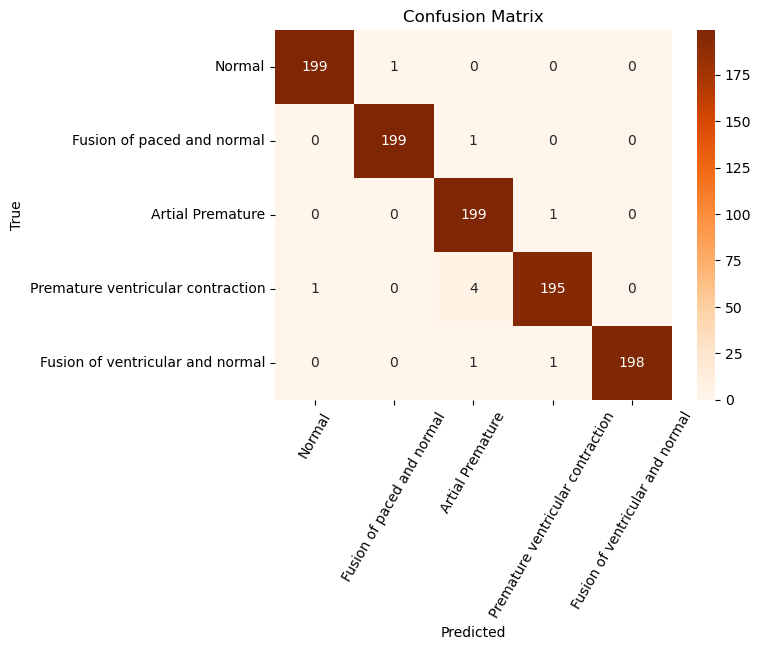

In [154]:
print_cm(y_test, y_test__predict)

In [156]:
with open(f'./fedot_model_task6.pkl', 'wb') as f:
    pickle.dump(automl_model, f)

In [158]:
with mlflow.start_run(run_name='FEDOT'):
    y_train__predict = automl_model.predict(X_train)
    y_test__predict = automl_model.predict(X_test)
    mlflow.log_params(
        {
            'problem':'classification',
            'preset': 'fast_train',
            'available_operations': ['rf', 'logit','mlp', 'xgboost'],
            'with_tuning': True,
            'n_jobs': -1,
            'seed': 42
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy для обучающих данных': accuracy_score(y_train, y_train__predict),
            'Accuracy для тестовых данных': accuracy_score(y_test, y_test__predict),
        }
    )
    mlflow.log_artifact('./fedot_model_task6.pkl')
    
    model_info = mlflow.sklearn.log_model(
        sk_model=automl_model,
        artifact_path='fedot_model_task6',
        signature=infer_signature(X_train, y_train__predict),
        input_example=X_train,
    )

🏃 View run FEDOT at: http://localhost:5000/#/experiments/760273242643663123/runs/b2c32f6c71e647998bc9371bf64e8145
🧪 View experiment at: http://localhost:5000/#/experiments/760273242643663123
